<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/heatonresearch_gan_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Install Software

Some software must be installed into Colab, for this notebook to work. We are specificially using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [ ]:
curr_dir = %pwd
print(curr_dir)

In [2]:
import os

curr_dir = %pwd

if os.path.isdir(f"{curr_dir}/stylegan2-ada-pytorch"):
    %cd "./stylegan2-ada-pytorch"
elif os.path.isdir("../stylegan2-ada-pytorch"):
  print(f"Current dir: {curr_dir}")
else:
    !git clone https://github.com/mgzzl/stylegan2-ada-pytorch
    %cd stylegan2-ada-pytorch
    !mkdir pretrained
    %cd pretrained
    # !gdown --id 1-5xZkD8ajXw1DdopTkH_rAoCsD72LhKU
    %cd ../

!pip install opensimplex

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 535, done.
remote: Total 535 (delta 0), reused 0 (delta 0), pack-reused 535
Receiving objects: 100% (535/535), 8.77 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (306/306), done.
/content/stylegan2-ada-pytorch
/content/stylegan2-ada-pytorch/pretrained
/content/stylegan2-ada-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import os
import sys
import torch

!pip install ninja
!pip install opensimplex
!pip install imageio-ffmpeg

import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display_lowres(img):
  plt.imshow(img)
  plt.title('neural_poster')
  plt.show()

def seed2vec(g, seed):
  return np.random.RandomState(seed).randn(1, g.z_dim)

def load_vec(filename):
  result = np.load(filename)
  return result if 'w' not in result else result['w']

def load_vec_from_dir(dir):
  if os.path.isdir(dir):
    # list to store loaded npy-files
    lvec_list = []

    # Iterate directory
    for filename in os.listdir(dir):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir, filename)) and filename.endswith('.npy'):
        lvec_list.append(load_vec(os.path.join(dir, filename))) 
    return lvec_list
    
  else:
    print(f"lvec directory does not exist/n{dir}")

def save_vec(filename, lvec):
  np.save(filename,lvec)

def to_image(img):
  return PIL.Image.fromarray(img, 'RGB')

def render_gan(G, device, lvec, label=None, truncation_psi=1, noise_mode='const'):
  # noise mode 'const', 'random', 'none'
  z = torch.from_numpy(lvec).to(device)
  if label is None: label = torch.zeros([1, G.c_dim], device=device)
  print(lvec.shape)
  if len(lvec.shape) == 2:
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  else:
    img = G.synthesis(z, noise_mode=noise_mode)
  
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load a Pretrained GAN

In [23]:
STYLEGAN2_PKL_URL = "/content/drive/MyDrive/Pretrained PKL/PosterGAN2-training_steps/network-snapshot-007800.pkl"
# STYLEGAN2_PKL_URL = "/content/drive/MyDrive/Pretrained PKL/PosterGAN2-training_steps/network-snapshot-010000.pkl"
# STYLEGAN2_PKL_URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-70s-scifi/releases/download/v1/70s-scifi-gan-2020-12-12.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-minecraft/releases/download/v1/minecraft-gan-2020-12-22.pkl"


device = torch.device('cuda')
with dnnlib.util.open_url(STYLEGAN2_PKL_URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# Generate GAN Images from Seeds

## Presettings
Some Variables for Process

In [11]:
num_of_seeds = 25
OUTDIR = "./out/generations"
vecDir = f"{OUTDIR}/vec"
imgDir = f"{OUTDIR}/img" 

import os
from pathlib import Path
import random

seeds = random.sample(range(0, 999999), num_of_seeds)

# Create directory
try:
    os.makedirs(OUTDIR)
    os.makedirs(vecDir)
    os.makedirs(imgDir)
except OSError:
    pass

print(f"Outputdirectory: {OUTDIR}\nSEEDS: {seeds}")
txt = '/test.txt'

Outputdirectory: ./out/generations
SEEDS: [988021, 578082, 424603, 751913, 697599, 151814, 190377, 467757, 531109, 755950, 13293, 278500, 581505, 115831, 803104, 39766, 45813, 663049, 944975, 971244, 456794, 646309, 715204, 398052, 15010]


## Generate Images

In [12]:
# Generate images.

for seed_idx, seed in enumerate(seeds):
  print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
  lv = seed2vec(G, seed)
  save_vec(f'{vecDir}/vec-{seed}', lv)
  img = render_gan(G, device, lv)
  img.save(f'{imgDir}/seed-{seed:09d}.png') # Save it
  #display(img2) # Display hi-res
  display_lowres(img)

Output hidden; open in https://colab.research.google.com to view.

# Convert Image to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [ ]:
SOURCE_NAME = "source-target.png"
OUT = "./out/projected_img/"

cmd = f"python ./projector.py --seed 303 --save-video 0 --num-steps 1000 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL}"
!{cmd}

In [ ]:
import cv2
import os
from matplotlib import pyplot as plt

img_gan_source = cv2.imread(os.path.join(OUT,'proj.png'))
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('poster-gan')
plt.show()

# Generate Interpolation from latent vector

First, we load the source latent vector.  Then we will create a Interpolation.

## Presettings
Some Variables for Process

In [7]:
# presettings for building the video
STEPS = 150 #Steps between generated Images
FPS = 30 #How much frames per seconde?
FREEZE_STEPS = 0 #Freezing Steps for first_img before morphing to sec_img
vecDir = "./out/generations/vec"

## Load a Saved Latent Vector and Display

In [ ]:
lvec = load_vec(f"{vecDir}/projected_w.npy")
img = render_gan(G, device, lvec)
display_lowres(img)

## Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [10]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

## TODO: return list with loaded npy files

lvec = load_vec_from_dir(vecDir)
network_pkl = STYLEGAN2_PKL_URL
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer(f'{OUTDIR}/Interpolation.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for i in range(len(lvec)-1):
  lvec1 = lvec[i]
  lvec2 = lvec[i+1]

  diff = lvec2 - lvec1
  step = diff / STEPS
  current = lvec1.copy()

  for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    label=None
    truncation_psi=1
    noise_mode='const'
    if label is None: label = torch.zeros([1, G.c_dim], device=device)
    synth_image = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1
    
    for i in range(repeat):
      video.append_data(synth_image)
    current = current + step


video.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [40]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
        nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class'\
                   'when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running '\
            'on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, 
                   noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, 
          noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128)\
    .clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

## Presettings
Some Variables for Process

In [ ]:
START_SEED = 4022

current = seed2vec(G, START_SEED)

In [48]:
%pwd

'/content/stylegan2-ada-pytorch'

In [51]:
num_of_seeds = 25
OUTDIR = "./out/generations"
directionDir = f"{OUTDIR}/Seed-{START_SEED}/direction"

import os
from pathlib import Path
import random
# Create directory
try:
    os.makedirs(OUTDIR)
    os.makedirs(directionDir)
except OSError:
    pass

print(f"Outputdirectory: {OUTDIR}")

In [52]:
print(directionDir)

./out/generations/direction


## Fine-tune an Image

If you find a seed you like, you can fine-tune it by directly adjusting the latent vector.  First, choose the seed to fine-tune.

In [53]:
START_SEED = 4022

current = seed2vec(G, START_SEED)

Next, generate and display the current vector. You will return to this point for each iteration of the finetuning.

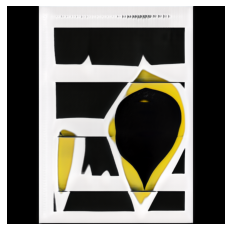

In [54]:
img = generate_image(device, G, current)

SCALE = 0.5
display_image(img)

Choose an explore size; this is the number of different potential images chosen by moving in 10 different directions.  Run this code once and then again anytime you wish to change the ten directions you are exploring.  You might change the ten directions if you are no longer seeing improvements.

In [55]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Each image displayed from running this code shows a potential direction that we can move in the latent vector.  Choose one image that you like and change MOVE_DIRECTION to indicate this decision.  Once you rerun the code, the code will give you a new set of potential directions.  Continue this process until you have a latent vector that you like.

Generating image for Direction 0


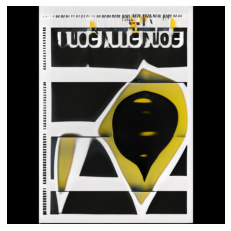

Generating image for Direction 1


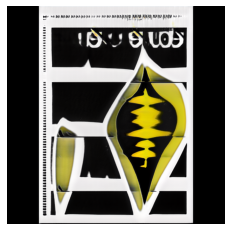

Generating image for Direction 2


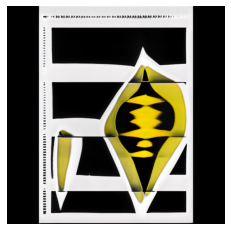

Generating image for Direction 3


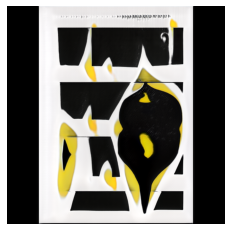

Generating image for Direction 4


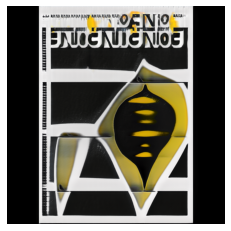

Generating image for Direction 5


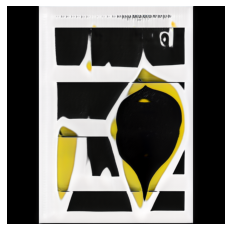

Generating image for Direction 6


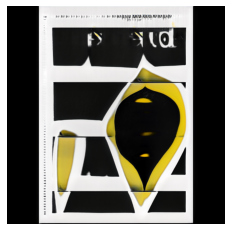

Generating image for Direction 7


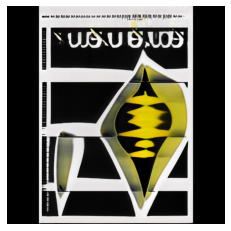

Generating image for Direction 8


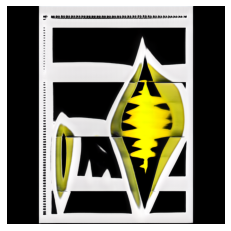

Generating image for Direction 9


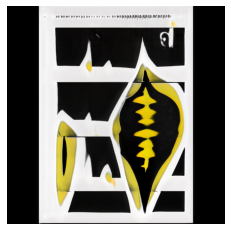

Generating image for Direction 10


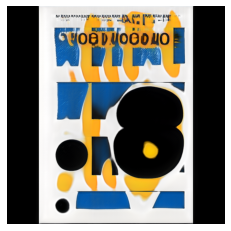

Generating image for Direction 11


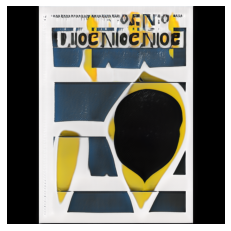

Generating image for Direction 12


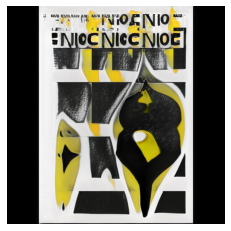

Generating image for Direction 13


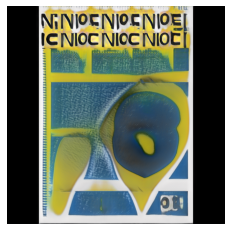

Generating image for Direction 14


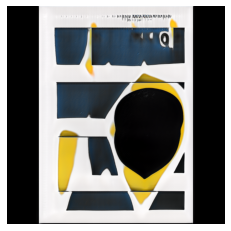

Generating image for Direction 15


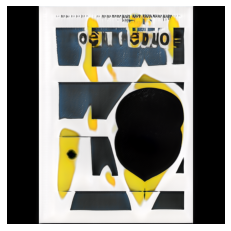

Generating image for Direction 16


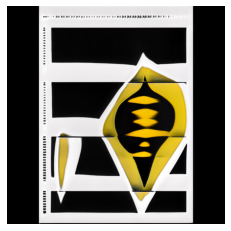

Generating image for Direction 17


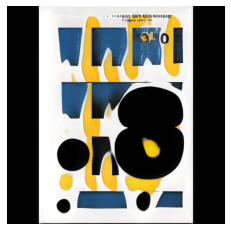

Generating image for Direction 18


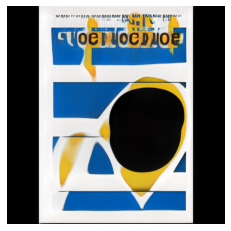

Generating image for Direction 19


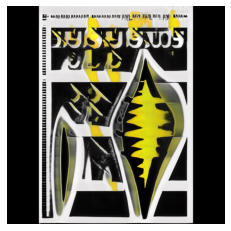

Generating image for Direction 20


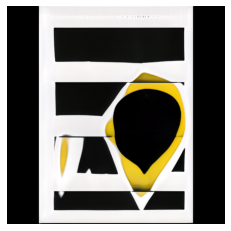

Generating image for Direction 21


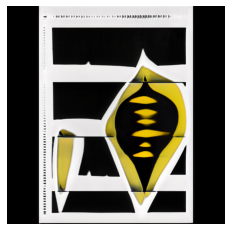

Generating image for Direction 22


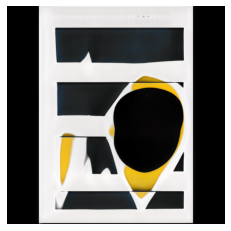

Generating image for Direction 23


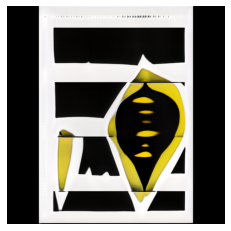

Generating image for Direction 24


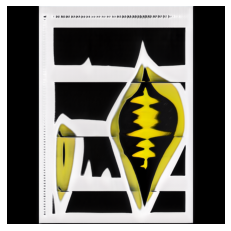

In [57]:
# HIDE OUTPUT 1
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f'Generating image for Direction {i}')
  z = current + mv
  img = generate_image(device, G, z)
  img.save(f'{directionDir}/seed-{START_SEED:09d}-direction{i}.png')
  display_image(img)
  # lv = seed2vec(G, z)
  # save_vec(f'{vecDir}/vec-{START_SEED:09d}-direction{i}', lv)